Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.initializers import glorot_uniform
from keras import backend as K
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
directory = cwd.replace("\\", "/")[:-9]

Define f1_score

In [2]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Prefetch the datasets

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# It is assumed that the training and testing directories contain the same distribution of data. 
# Hence the validation dataset is sampled from the training set.
train_dataset, validation_dataset = image_dataset_from_directory(directory+"/images/training/",
                                                                 shuffle=True,
                                                                 validation_split = 0.2,
                                                                 subset = 'both',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 seed=42)

test_dataset = image_dataset_from_directory(directory+"/images/testing/",
                                            shuffle=False,
                                            batch_size=597,
                                            image_size=IMG_SIZE,
                                            seed=42)

class_names = train_dataset.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

print(f'The class names are: {class_names}')

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Using 478 files for validation.
Found 597 files belonging to 2 classes.
The class names are: ['flip', 'notflip']


Define the preprocessing function

In [4]:
tf.random.set_seed(42)

preprocess_input = tfl.Rescaling(scale=1/255, offset=0.0, name='preprocess')

Define the BottleneckBlock object, as described in MobileNetV2

In [5]:
class BottleneckBlock(tf.keras.layers.Layer):
    """
    Bottleneck block from MobileNetV2
    
    Constructor arguments:
    f -- integer, shape of the convolutional window
    nb_depth -- number of filters to expand to for the depthwise convolution
    nb_project -- number of filters for the projection
    
    """
    def __init__(self, f, nb_depth, nb_proj, **kwargs):
        super(BottleneckBlock, self).__init__(**kwargs)
        self.expconv = tfl.Conv2D(filters = nb_depth, 
                                  kernel_size = (1,1), 
                                  strides = (1,1), 
                                  padding = 'same', 
                                  kernel_initializer = glorot_uniform(seed=42),
                                  name = 'expconv'
                                  )
        self.expbatch = tfl.BatchNormalization(axis = 3, name = 'expbatch')
        self.depthconv = tfl.DepthwiseConv2D(kernel_size = (f,f), 
                                             strides = (1,1), 
                                             padding = 'same', 
                                             kernel_initializer = glorot_uniform(seed=42),
                                             name = 'depthconv'
                                             )
        self.depthbatch = tfl.BatchNormalization(axis = 3, name = 'depthbatch')
        self.projconv = tfl.Conv2D(filters = nb_proj, 
                                   kernel_size = (1,1), 
                                   strides = (1,1), 
                                   padding = 'same', 
                                   kernel_initializer = glorot_uniform(seed=42),
                                   name = 'projconv'
                                   )
        self.projbatch = tfl.BatchNormalization(axis = 3, name = 'projbatch')
        self.shortbatch = tfl.BatchNormalization(axis = 3, name = 'shortbatch')
        self.nb_depth = nb_depth
        self.nb_proj = nb_proj
        self.f = f
    
    def call(self, X):
        X_shortcut = X # Saved for the shortcut connection
    
        # Expansion Part
        X = self.expconv(X)
        X = self.expbatch(X)
        X = tfl.Activation('relu')(X)
        
        # Depthwise Convolution Part
        X = self.depthconv(X)
        X = self.depthbatch(X)
        X = tfl.Activation('relu')(X)
        
        # Projection Part
        X = self.projconv(X)
        X = self.projbatch(X)
        
        # Shortcut Connection
        if self.nb_proj == X_shortcut.shape[3]:
            X_shortcut = self.shortbatch(X_shortcut)
            X = tfl.add([X, X_shortcut])
        X = tfl.Activation('relu')(X)
    
        return X
    
    def get_config(self):
        config = super(BottleneckBlock, self).get_config()
        config.update({"f": self.f, "nb_depth": self.nb_depth, "nb_proj": self.nb_proj})
        return config

Define the custom model

In [6]:
def flip_model(input_shape=(224,224), f=3, data_augmentation=tf.identity):
    """
    A custom architecture for the binary classification of flip/notflip images

    Arguments:
    input_shape -- shape of the images of the dataset
    f -- integer, shape of the convolutional window
    
    """

    X_input = tf.keras.Input(shape=input_shape, name = 'input')
    
    X = data_augmentation(X_input)
    
    X = preprocess_input(X)
    
    X = tfl.Conv2D(6, 
                   (3, 3), 
                   strides = (2, 2), 
                   padding = 'same', 
                   kernel_initializer = glorot_uniform(seed=42),
                   name = 'Conv2D_1'
                   )(X)
    X = tfl.BatchNormalization(axis = 3, name = 'BatchNorm_1')(X)
    X = tfl.Activation('relu', name = 'ReLU_1')(X)
    X = tfl.MaxPooling2D(pool_size = (2, 2), 
                         strides = (2, 2),
                         name = 'MaxPool2D_1'
                         )(X)
    X = tfl.Dropout(0.01, 
                    seed = 42,
                    name = 'Dropout_1'
                    )(X)
    
    Block1 = BottleneckBlock(f, 
                             24, 
                             6, 
                             name='Bottleneck_1'
                             )
    X = Block1(X)
    X = tfl.MaxPooling2D(pool_size = (2, 2),
                         name = 'MaxPool2D_2')(X)
    X = tfl.Dropout(0.01, 
                    seed=42,
                    name = 'Dropout_2'
                    )(X)
    
    Block2 = BottleneckBlock(f, 
                             48, 
                             6, 
                             name='Bottleneck_2'
                             )
    X = Block2(X)
    X = tfl.MaxPooling2D(pool_size = (2, 2),
                         name = 'MaxPool2D_3')(X)
    X = tfl.Dropout(0.1, 
                    seed = 42,
                    name = 'Dropout_3'
                    )(X)
    
    X = tfl.Flatten(name = 'Flatten')(X)
    X_output = tfl.Dense(units = 1, 
                         activation = 'sigmoid', 
                         kernel_initializer = glorot_uniform(seed=42),
                         name = 'Dense'
                         )(X)
    
    model = tf.keras.Model(inputs = X_input, outputs = X_output, name = 'flip_model')
    
    return model

In [7]:
# IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
f = 3 # kernel size

# Creating the model instance
augment_data = tf.identity # No data augmentation is needed for this task
custom_model = flip_model(input_shape=IMG_SHAPE, f=f, data_augmentation=augment_data)
custom_model.trainable = True
print('A summary of the model follows:\n')
summary = custom_model.summary()

A summary of the model follows:

Model: "flip_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.identity (TFOpLambda)    (None, 224, 224, 3)       0         
                                                                 
 preprocess (Rescaling)      (None, 224, 224, 3)       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 112, 112, 6)       168       
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 112, 112, 6)      24        
 tion)                                                           
                                                                 
 ReLU_1 (Activation)         (None, 112, 112, 6)       0         
                       

Compiling the model

In [8]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0005, 
                                                             decay_steps = len(train_dataset), 
                                                             decay_rate = 0.96, 
                                                             staircase = True
                                                             )

optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

metrics = ['accuracy', f1_score]
 
custom_model.compile(loss = loss_function,
                     optimizer = optimizer,
                     metrics = metrics
                     )

In [9]:
loss_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 0.0002,
                                                 patience = 10
                                                 )

acc_callback = tf.keras.callbacks.EarlyStopping(monitor ='val_accuracy', 
                                                min_delta = 0.001, 
                                                patience = 30
                                                )

checkpoints = tf.keras.callbacks.ModelCheckpoint('./checkpoints/custom_model',
                                                monitor = 'val_loss',
                                                save_best_only = True, 
                                                save_weights_only = True,
                                                save_freq = 'epoch'
                                                )

history = custom_model.fit(train_dataset,
                           epochs = 100,
                           validation_data = validation_dataset,
                           callbacks = [loss_callback, acc_callback, checkpoints]
                           )

Epoch 1/100
60/60 [==============================] - 19s 230ms/step - loss: 0.6596 - accuracy: 0.6411 - f1_score: 0.6388 - val_loss: 0.6966 - val_accuracy: 0.4749 - val_f1_score: 0.0000e+00
Epoch 2/100
60/60 [==============================] - 14s 228ms/step - loss: 0.4201 - accuracy: 0.7994 - f1_score: 0.7981 - val_loss: 0.7207 - val_accuracy: 0.4749 - val_f1_score: 0.0000e+00
Epoch 3/100
60/60 [==============================] - 18s 283ms/step - loss: 0.2985 - accuracy: 0.8809 - f1_score: 0.8818 - val_loss: 0.7570 - val_accuracy: 0.4749 - val_f1_score: 0.0000e+00
Epoch 4/100
60/60 [==============================] - 24s 385ms/step - loss: 0.2419 - accuracy: 0.9086 - f1_score: 0.9075 - val_loss: 0.7106 - val_accuracy: 0.4770 - val_f1_score: 0.0089
Epoch 5/100
60/60 [==============================] - 25s 397ms/step - loss: 0.1970 - accuracy: 0.9300 - f1_score: 0.9312 - val_loss: 0.6062 - val_accuracy: 0.5941 - val_f1_score: 0.4064
Epoch 6/100
60/60 [==============================] - 25s 4

Epoch 45/100
60/60 [==============================] - 19s 305ms/step - loss: 0.0212 - accuracy: 0.9974 - f1_score: 0.9975 - val_loss: 0.0240 - val_accuracy: 0.9937 - val_f1_score: 0.9937
Epoch 46/100
60/60 [==============================] - 19s 301ms/step - loss: 0.0204 - accuracy: 0.9969 - f1_score: 0.9964 - val_loss: 0.0246 - val_accuracy: 0.9916 - val_f1_score: 0.9923
Epoch 47/100
60/60 [==============================] - 19s 296ms/step - loss: 0.0252 - accuracy: 0.9943 - f1_score: 0.9943 - val_loss: 0.0273 - val_accuracy: 0.9916 - val_f1_score: 0.9923
Epoch 48/100
60/60 [==============================] - 19s 301ms/step - loss: 0.0210 - accuracy: 0.9969 - f1_score: 0.9964 - val_loss: 0.0278 - val_accuracy: 0.9916 - val_f1_score: 0.9923
Epoch 49/100
60/60 [==============================] - 25s 399ms/step - loss: 0.0243 - accuracy: 0.9953 - f1_score: 0.9944 - val_loss: 0.0228 - val_accuracy: 0.9916 - val_f1_score: 0.9923
Epoch 50/100
60/60 [==============================] - 26s 414ms/s

Saving the model and its weights

In [10]:
custom_model.load_weights('./checkpoints/custom_model') # weights from best epoch
custom_objects = {"BottleneckBlock": BottleneckBlock, "f1_score": f1_score}
custom_model.save('./checkpoints/custom_model.h5')

Plotting the loss and accuracy history

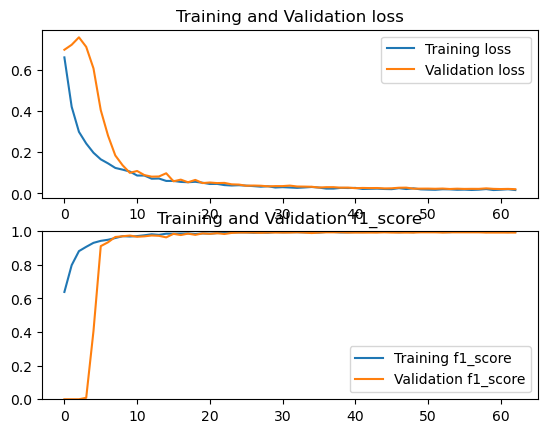

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

plt.figure()
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.subplot(2,1,2)
plt.plot(f1, label = 'Training f1_score')
plt.plot(val_f1, label = 'Validation f1_score')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.title('Training and Validation f1_score')
plt.show()

Evaluate on the test set

In [12]:
print('\nEvaluating the model on the test set\n')
custom_model.evaluate(test_dataset)
test_predictions = custom_model.predict(test_dataset)


Evaluating the model on the test set

1/1 [==============================] - 3s 3s/step


Verifying that the saved custom model can be loaded

In [13]:
loaded_model = tf.keras.models.load_model('./checkpoints/custom_model.h5', custom_objects=custom_objects)

print('\nEvaluating the model on the test set\n')
loaded_model.evaluate(test_dataset)
test_predictions = loaded_model.predict(test_dataset)


Evaluating the model on the test set

1/1 [==============================] - 3s 3s/step
